# Explore Previously Made Models
### Matthew Muller
11/29/2022

## General Housekeeping

In [77]:
##########
# Library Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA, NMF, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import roc_curve, confusion_matrix
from joblib import load

from scipy.stats import kruskal, zscore

from MattTools.plotting import plot_roc_curve, plot_confusion_matrix, plot_training_roc_curve_ci, plot_roc_curve_ci
from MattTools.plotting import plot_scree, plot_training_probas
from MattTools.stats import bootstrap_auc_confidence
from MattTools import utils

utils.hide_warnings()

##########
# Set/Append Working directory
%cd ~/Ruggles Lab Dropbox/Matthew Muller/projects/platelet-activity

/Users/muller/Ruggles Lab Dropbox/Matthew Muller/projects/platelet-activity


## Load in data
Here we load in:
- Pace
- Duke
- Models

In [78]:
## Load in saved models
models = [
        # load('models/jobs/pace_plt_model.joblib')[-1], # this is a pipe, so I'm selecting just the model,
        load('models/jobs/press_01_model_voting_a_ton_of_trees.joblib'),

        ]

## Load in pace data
path = 'data/clean/'
X_pace = pd.read_csv(path+'pace/features.csv')
y_pace = pd.read_csv(path+'pace/labels.csv').to_numpy()[:,0]


## Load in duke data
X_duke = pd.read_csv(path+'duke/features_group1.csv')
y_duke = pd.read_csv(path+'duke/labels_group1.csv').to_numpy()[:,0]

X_gse65705 = pd.read_csv('output/GSE65705_hyper_preds/GSE65705_press_counts.csv', index_col=0).sort_index().T
y_gse65705 = pd.read_csv('output/GSE65705_hyper_preds/GSE65705_labels.csv').to_numpy().flatten()

X_pace_all = pd.read_csv('data/clean/pace_norm_all.csv', index_col=0).T
# order the columns
X_pace_all = X_pace_all.reindex(sorted(X_pace_all.columns), axis=1)

X_feature_outtable = pd.read_csv('data/hyper_feature_outtable.csv', index_col=0)
# change the index to remove _
X_feature_outtable.index = X_feature_outtable.index.str.replace('_', '')

############################################################################################################
## Set test and train data
X_train = X_pace
y_train = y_pace

X_test = X_duke
y_test = y_duke

In [79]:
for model in models:
    print(model.get_params())

{'memory': None, 'steps': [('scaler', StandardScaler()), ('voting', VotingClassifier(estimators=[('rf0',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_features='log2',
                                                     n_estimators=80,
                                                     random_state=1148093)),
                             ('rf1',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_features='log2',
                                                     n_estimators=80,
                                                     random_state=1095286)),
                             ('rf2',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_features='log2',
                                                     n_estimators=80,
 

## Feature Importance of Models
Model feature (gene) importance examined through mean decrease in impurity from each feature

In [80]:
# for idx, model in enumerate(models):
#     ## Feature Selection
#     pace_importances = model.feature_importances_
#     genes = pd.read_csv('data/clean/press_genes.csv', header=None)[0]
#     # genes = subset

#     ## Plot top 20 most important features in pace
#     forest_importances = pd.Series(pace_importances, index=genes)
#     forest_importances = forest_importances.sort_values(ascending = False)[0:40]

#     fig, ax = plt.subplots(figsize=(12, 8))
#     forest_importances.plot.bar(ax=ax)
#     ax.set_title(f"Feature importances of Model {idx+1} (Total Variance: {forest_importances.sum():.2f})")
#     ax.set_ylabel("Mean decrease in impurity")
#     ax.set_xlabel("Genes")
#     fig.tight_layout()
#     plt.show()

## Training results for models
- Bootstrapped ROC AUC curves for CV training within the models
- boxplots of prediction probability for the models

In [81]:
from sklearn.inspection import permutation_importance
# import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Function to plot the test probabilities of a model using cross validation
def plot_training_probas(model, X, y, 
                         cv=StratifiedKFold(n_splits=5), 
                         plot=sns.boxplot, save_path=None, title=None, *args):
    """
    Summary:
    --------
    Plots the training probabilities of a model using cross validation

    Parameters:
    -----------
    model (sklearn model) : sklearn model to be used
    X (np.array or pd.DataFrame) : np array of features used
    y (np.array) : list of labels used for classes
    cv (resampler) : resampler to use for cross validation
    plot (sns plot) : seaborn plot to use
    save_path (str) : path to save plot to
    *args (dict) : *args to pass to seaborn plot
    """
    # check if X is a numpy array
    if not isinstance(X, np.ndarray):
        try:
            X = X.to_numpy()
        except:
            raise TypeError("X must be a numpy array or convertible to one")

    # CV setup
    model = clone(model)

    # get scores
    scores = []
    labels = []
    for fold, (train, test) in enumerate(cv.split(X, y)):
        model.fit(X[train], y[train])

        labels += list(y[test])
        scores += list(model.predict_proba(X[test])[:, 1])

    # convert to dataframe
    df = pd.DataFrame({"preds": scores})
    df["labels"] = labels

    # zscore the data
    df["scores"] = zscore(df["preds"])

    # set title
    if not title:
        title = "Distribution of Prediction Scores by Class"

    # plot the data
    sns.set_theme(style="whitegrid", palette="colorblind")
    ax = plot(df, x="labels", y="preds", order=np.unique(df["labels"]), *args)
    ax.set(ylabel="Prediction Score", xlabel="Labels", title=title)

    # statistical annotation
    groups = [df.loc[df["labels"] == label, "preds"] for label in np.unique(df["labels"])]
    kruskal_wallis = kruskal(*groups)
    if kruskal_wallis.pvalue < 0.05:
        x1, x2 = 0, 1
        y, h = df["preds"].max() + 0.02, 0.01
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c="k")
        ax.text((x1 + x2) * 0.5, y + h, f"p = {kruskal_wallis.pvalue:.4f}", ha="center", va="bottom", color="k")
    # save or show
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

    return(df)

This function will be defunct in the future. Please use plot_cross_validation_auroc instead.


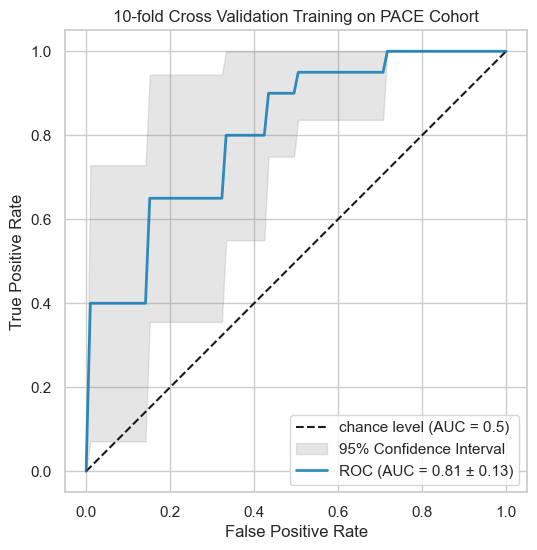

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Prediction Score'),
 Text(0.5, 1.0, 'Distribution of Prediction Scores by Class')]

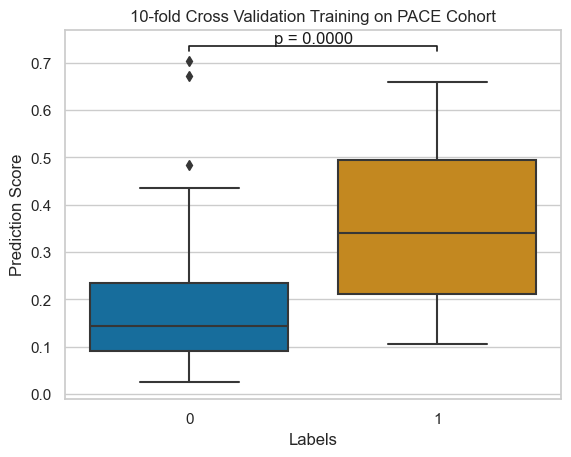

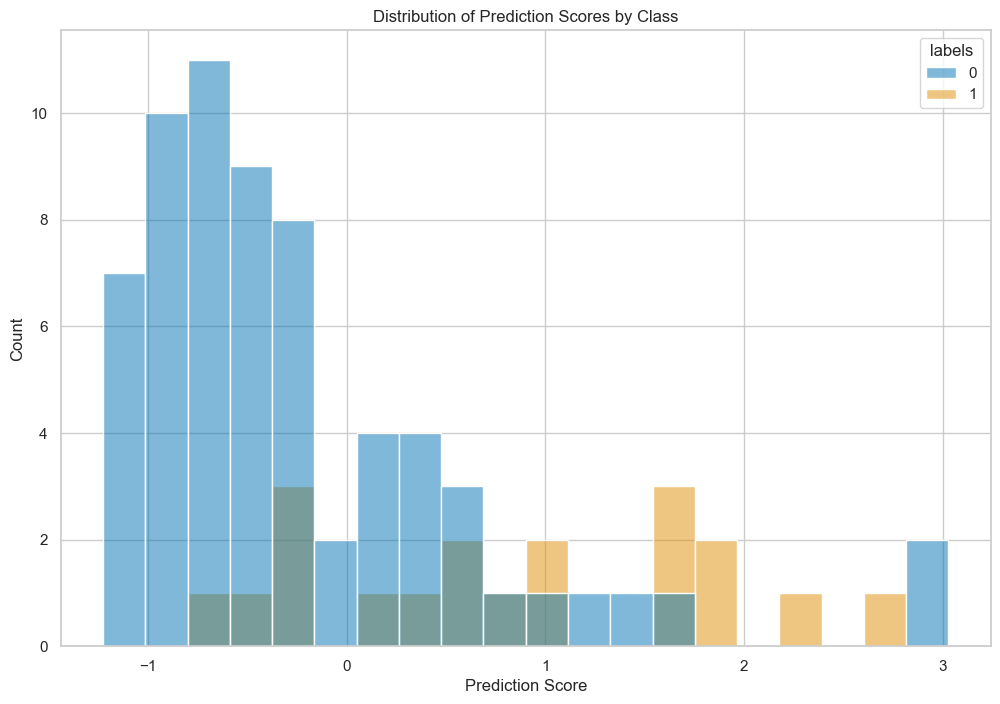

In [95]:
## Bootstrapped ROC AUC curves for CV training
for model in models:
    plot_training_roc_curve_ci(
        model, X_train, y_train,
        title='10-fold Cross Validation Training on PACE Cohort',
        cv = StratifiedKFold(n_splits=10),
        save_path = '/Users/muller/Desktop/pace_edits/fig_3/fig_3F.pdf',
        )
    plt.show()
    

    export = plot_training_probas(
        model, X_train, y_train,
        title='10-fold Cross Validation Training on PACE Cohort',
        cv = StratifiedKFold(n_splits=10),
        save_path = '/Users/muller/Desktop/pace_edits/fig_3/fig_3E.pdf'
    )
    
# plot the export as two histograms
sns.set_theme(style="whitegrid", palette="colorblind")
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=export, x="scores", hue="labels", ax=ax, bins=20)
ax.set(ylabel="Count", xlabel="Prediction Score", title="Distribution of Prediction Scores by Class")

# save the export
# export.to_csv('output/pace_scores_press_01.csv', index=False)

In [99]:
# get the p value in the training probs plot
def get_p_value(df):
    groups = [df.loc[df["labels"] == label, "preds"] for label in np.unique(df["labels"])]
    kruskal_wallis = kruskal(*groups)
    return(kruskal_wallis.pvalue)

# call the function
get_p_value(export)

3.121369183623256e-05

[-0.76015397  0.65545373 -1.10402009  0.32947973  0.8994224  -0.93599084
 -1.14201053 -0.34987342 -0.36434288  1.01161625  0.86820138  0.05143146
  1.28160207  1.00159633 -0.5913583   2.16199699  0.06343221  0.10524636
  0.51298279 -0.44986188  1.27559936  0.2104518   1.86377504  2.45107671
 -0.38783433 -0.0178674   2.25238166  1.20674977 -1.04277317 -0.7068538
 -0.87166297  1.57181806 -0.03987729 -0.9571177  -1.21471985 -1.13694344
 -0.98976245  0.11291111 -0.1414802  -0.1110152   0.95837017 -0.76967586
  2.43848278  2.1085264  -0.99017128  0.01370049 -0.40577654  0.06445529
  0.89289364  1.72956797  1.8552207  -0.95705735  0.60153009  0.55677854
  0.16789667]


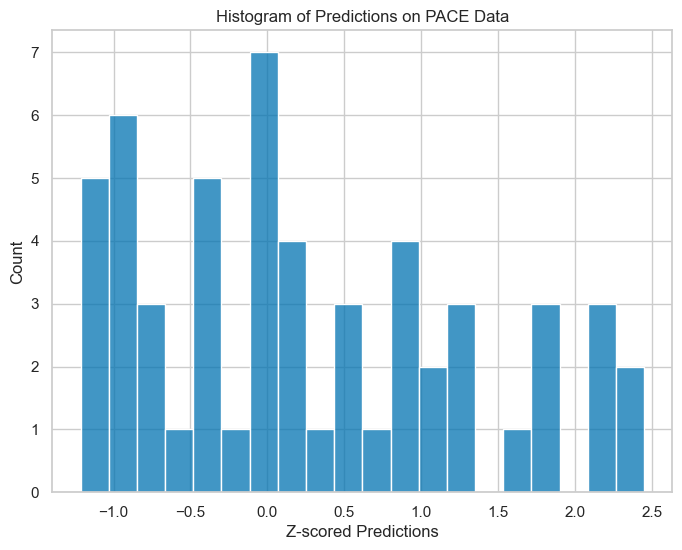

In [83]:
# get the row indices for the X_pace_all and X_feature_outtable
X_pace_all_idx = X_pace_all.index.intersection(X_feature_outtable.index)

# replace the values in X_pace_all with the values from X_feature_outtable
X_pace_all.loc[X_pace_all_idx, :] = X_feature_outtable.loc[X_pace_all_idx, :]

# remove the rows that are in X_pace_all_idx from X_pace_all.loc
X_pace_all = X_pace_all.loc[~X_pace_all.index.isin(X_pace_all_idx), :]

# get the shape
X_pace_all.shape

# get predictions for each model for the X_pace_all data
pace_names = X_pace_all.index

# make a scaler
pred_scaler = StandardScaler()
pred_scaler.fit(export[['preds']])

# fit the scaler with the cross validation data

for model in models:
    preds = model.predict_proba(X_pace_all)[:,1]
    label = model.predict(X_pace_all)
    scoring = pred_scaler.transform(preds.reshape(-1, 1))
    print(scoring.reshape(-1))
    scores = pd.DataFrame({'pace':pace_names, 'scores':scoring.reshape(-1), 'preds':preds})

    # plot the scores as a histogram
    fig, ax = plt.subplots(figsize=(8,6))
    sns.histplot(data=scores, x='scores', ax=ax, bins=20)
    ax.set_xlabel('Z-scored Predictions')
    ax.set_ylabel('Count')
    ax.set_title('Histogram of Predictions on PACE Data')

    # save the scores
    scores.to_csv('output/pace_predictions_press_01.csv', index=False)

In [84]:
export

,preds,labels,scores
0,0.038471,0,-1.136478
1,0.130015,1,-0.564348
2,0.066725,0,-0.959894
3,0.137991,0,-0.514504
4,0.166494,0,-0.336365
...,...,...,...
79,0.056225,0,-1.025515
80,0.095247,0,-0.781639
81,0.121869,0,-0.615260
82,0.521108,1,1.879872


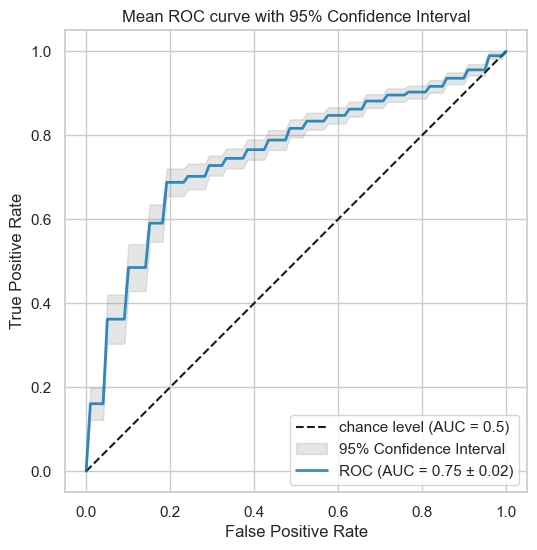

In [85]:
## Bootstrapped ROC AUC curves
for model in models:
    plot_roc_curve_ci(
        model, X_test, y_test,
        # save_path='/Users/muller/Desktop/pace_edits/fig_4/fig_4D.pdf',
        )
    # bootstrap_auc_confidence(
    #     model.predict_proba(X_test)[:,1],
    #     y_test,
    #     n_bootstraps=1000, 
    #     plot_histogram=True
    #     )

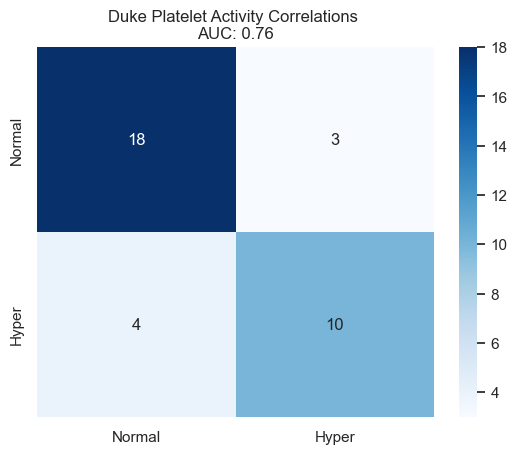

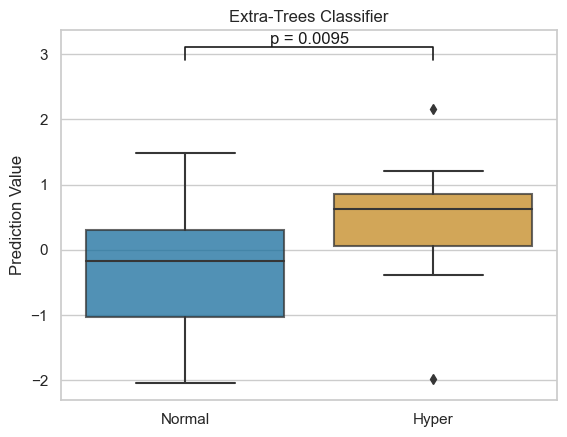

In [90]:
## Boxplots of Duke Hyper v. Hypo
features, labels = X_test, y_test
for idx, model in enumerate(models):
    # Predict and graph things
    preds = model.predict(features)
    conf_matrx = confusion_matrix(labels, preds)
    auc_score = roc_auc_score(labels, model.predict_proba(features)[:,1])


    sns.heatmap(conf_matrx, xticklabels=["Normal", "Hyper"], yticklabels=["Normal", "Hyper"],
                cmap="Blues", annot=True, fmt='g').set_title(f"Duke Platelet Activity Correlations \nAUC: {auc_score:.2f}")
    plt.savefig('/Users/muller/Desktop/pace_edits/fig_4/fig_4E.pdf')
    plt.show()

    # Weird results here, so I figure making a histogram of the model is helpful
    sns.set_theme(style="whitegrid", palette="colorblind")
    df = pd.DataFrame({'preds' : model.predict_proba(features)[:,1]}).apply(zscore)
    df['labels'] = labels
    df['labels'] = df['labels'].map({0:"Normal", 1:"Hyper"})
    sns.boxplot(
        df, x='labels', y='preds', 
        order=["Normal", "Hyper"], boxprops={'alpha': 0.75}
        ).set(ylabel="Prediction Value", xlabel=None, title=f"Extra-Trees Classifier")
    # sns.stripplot(
    #     df, x='labels', y='preds',
    #     color = 'black', alpha = 0.75,
    #     order=["Normal", "Hyper"]
    #     ).set(ylabel="Prediction Value", xlabel=None)

    # Significance Testing (kruskal-wallis for nonparametric analysis)    
    kruskal_wallis = kruskal(df.loc[df['labels'] == "Normal"]['preds'], df.loc[df['labels'] == "Hyper"]['preds'])
    if kruskal_wallis[1] < 0.05:
        # statistical annotation
        x1, x2 = 0, 1
        y, h = df['preds'].max()+0.75, 0.2
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.2, c='k')
        plt.text((x1+x2)*.5, y+h, f"p = {kruskal_wallis[1]:.4f}",
                 ha='center', va='bottom', color='k')
    plt.savefig('/Users/muller/Desktop/pace_edits/fig_4/fig_4C.pdf')
    plt.show()


## Feature Selection

In [87]:
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone

# Regrabbing it so I have feature names
X_pace = pd.read_csv(path+'pace/features.csv')

for model in models:
    sfm = SelectFromModel(model, prefit=True, threshold='mean')
    X_new = sfm.transform(X_train)
    print(f'{model} produced a feature subset of size {X_new.shape}')
    features = X_train.columns[sfm.get_support()]
    print(f'The features chosen are: {features.to_list()}\n')

    print(classification_report(y_test, clone(model).fit(X_new, y_train).predict(sfm.transform(X_test))))

ValueError: when `importance_getter=='auto'`, the underlying estimator Pipeline should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [ ]:
### Model Disease Correlations
### Load in disease gene ratio data
sle_ratios = pd.read_csv('data/clean/model_validation/sle/sle_features_labels.csv', index_col=0)
male_ratios = pd.read_csv('data/clean/model_validation/male/male_features_labels.csv', index_col=0)
mace_ratios = pd.read_csv('data/clean/model_validation/mace/mace_features_labels.csv', index_col=0)
covid_ratios = pd.read_csv('data/clean/model_validation/covid/covid_features_labels.csv', index_col=0)
pad_ratios = pd.read_csv('data/clean/model_validation/pad/pad_features_labels.csv', index_col=0)
harp_ratios = pd.read_csv('data/clean/model_validation/harp/harp_features_labels.csv', index_col=0)


### Load in disease gene ratio data
# sle_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/sle_gene_ratios_filtered_pace_60', index_col=0)
# male_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/male_gene_ratios_filtered_pace_60', index_col=0)
# mace_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/mace_gene_ratios_filtered_pace_60', index_col=0)
# covid_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/covid_gene_ratios_filtered_pace_60', index_col=0)
# pad_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/pad_gene_ratios_filtered_pace_60', index_col=0)
# harp_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/harp_gene_ratios_filtered_pace_60', index_col=0)

disease_ratios = {'sle':sle_ratios, 'male':male_ratios, 'mace':mace_ratios, 
                  'covid':covid_ratios, 'pad':pad_ratios, 'harp':harp_ratios}

### Prediction Results

for key in disease_ratios.keys():
    print(f'##################################### Current Disease: {key.upper()} #####################################')
    
    features = disease_ratios[key].drop('cohort', axis=1)
    labels = disease_ratios[key]['cohort']

    print(classification_report(labels, model.predict(features)))

    plot_roc_curve(labels, model.predict_proba(features)[:,1])


        # Predict and graph things
    preds = model.predict(features)
    conf_matrx = confusion_matrix(labels, preds)
    auc_score = roc_auc_score(labels, model.predict_proba(features)[:,1])


    sns.heatmap(conf_matrx, xticklabels=["Normal", "Hyper"], yticklabels=["Healthy", key],
                cmap="Blues", annot=True, fmt='g').set_title(f"{key} Platelet Activity Correlations \nAUC: {auc_score:.2f}")
    plt.show()


    # Weird results here, so I figure making a histogram of the model is helpful
    sns.set_theme(style="whitegrid", palette="colorblind")
    df = pd.DataFrame({'preds' : model.predict_proba(features)[:,1]}).apply(zscore)
    df['labels'] = labels.values
    df['labels'] = df['labels'].map({0:"Normal", 1:key})
    sns.boxplot(
        df, x='labels', y='preds', 
        order=["Normal", key], boxprops={'alpha': 0.75}
        ).set(ylabel="Prediction Value", xlabel=None)
    sns.stripplot(
        df, x='labels', y='preds',
        color = 'black', alpha = 0.75,
        order=["Normal", key]
        ).set(ylabel="Prediction Value", xlabel=None)

    # Significance Testing (kruskal-wallis for nonparametric analysis)    
    kruskal_wallis = kruskal(df.loc[df['labels'] == "Normal"]['preds'], df.loc[df['labels'] == key]['preds'])
    if kruskal_wallis[1] < 0.05:
        # statistical annotation
        x1, x2 = 0, 1
        y, h = df['preds'].max()+0.01, 0.01
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.2, c='k')
        plt.text((x1+x2)*.5, y+h, f"p = {kruskal_wallis[1]:.4f}",
                 ha='center', va='bottom', color='k')

    plt.show()